# MBTA Schedule Data: GTFS

This tutorial will guide you through MBTA's official General Transit Feed Specification (GTFS) datasets, which describe up-to-date network information, schedule and frequencies.

_We expect that GTFS data is best used for analyzing **service levels and quality (schedules, frequency and speed)**. If you only want geospatial data of the MBTA's network, [this other dedicated tutorial](mbta_network_geospatial.ipynb) may be simpler._

This tutorial contains:

* What is GTFS?
* Sources for MBTA's current and historical GTFS data
* A tutorial with Python analysis using the package ``pyGTFSHandler`` (thanks to our TransitMatters volunteers)
* Documentation of GTFS data

## Background: What is GTFS?

The General Transit Feed Specification (GTFS) is the standard format for public transportation data. It is typically stored as a ZIP file with many text files (``.txt``), each in comma-separated format, that describe aspects of the transit network (routes, stop, etc.) and schedule. The latest MBTA GTFS bundle consists of 32 such text files, which include ``routes.txt``, ``stops.txt`` and ``trips.txt``.

Each transit agency, such as the MBTA, typically releases its own GTFS data in public. Such datasets are then aggregated and fed into public map services, such as Google Maps, Apple Maps, and the [Transit mobile app](https://transitapp.com/); they are also used by fan sites such as [TransSee](https://www.transsee.ca/#Boston). For those services that display vehicle location data and estimated arrival times, they typically use a combination of GTFS schedules and real-time information from transit agencies.

In particular, GTFS is the primary and most reliable source of **trip schedules and frequencies**.

## MBTA's Official GTFS Data Sources

The MBTA website contains a [page on GTFS](https://www.mbta.com/developers/gtfs) for developers and data analysts. 

### Current GTFS Data

The latest GTFS bundle is always at this URL, updated regularly: 

[``https://cdn.mbta.com/MBTA_GTFS.zip``](https://cdn.mbta.com/MBTA_GTFS.zip)

### Historical GTFS Data

MBTA keeps track of archived GTFS files with historical schedules since 2009. A list of archives is available at this URL: https://cdn.mbta.com/archive/archived_feeds.txt. The official documentation of this table is [here](https://github.com/mbta/gtfs-documentation/blob/master/reference/gtfs-archive.md).

As an illustration:

In [1]:
import pandas as pd

GTFS_ARCHIVES_URL = f"https://cdn.mbta.com/archive/archived_feeds.txt"

gtfs_archives = pd.read_csv(GTFS_ARCHIVES_URL)

In [2]:
gtfs_archives

,feed_start_date,feed_end_date,feed_version,archive_url,archive_note
0,20251114,20251213,"Fall 2025, 2025-11-21T16:57:44+00:00, version D",https://cdn.mbtace.com/archive/20251114.zip,NaN
1,20251112,20251113,"Fall 2025, 2025-11-19T15:40:35+00:00, version D",https://cdn.mbtace.com/archive/20251112.zip,NaN
2,20251107,20251111,"Fall 2025, 2025-11-14T17:17:24+00:00, version D",https://cdn.mbtace.com/archive/20251107.zip,NaN
3,20251105,20251106,"Fall 2025, 2025-11-12T14:13:08+00:00, version D",https://cdn.mbtace.com/archive/20251105.zip,NaN
4,20251031,20251104,"Fall 2025, 2025-11-07T17:47:27+00:00, version D",https://cdn.mbtace.com/archive/20251031.zip,NaN
...,...,...,...,...,...
905,20090515,20090528,"GTFS file for Google Transit, published 5/15/09",https://cdn.mbtace.com/archive/20090515.zip,NaN
906,20090424,20090514,"GTFS file for Google Transit, published 4/24/09",https://cdn.mbtace.com/archive/20090424.zip,NaN
907,20090409,20090423,"GTFS file for Google Transit, published 4/9/09",https://cdn.mbtace.com/archive/20090409.zip,NaN
908,20090403,20090408,"GTFS file for Google Transit, published 4/3/09",https://cdn.mbtace.com/archive/20090403.zip,NaN


You can use the ``feed_start_date`` and ``feed_end_date`` fields to find the schedule applicable on a given date. The zip file in ``archive_url`` leads to the GTFS bundle.

## GTFS Documentation and Data Processing

You can find official documentation for the generic GTFS format [here](https://gtfs.org/documentation/schedule/reference/). MBTA provides additional documentation in [this GitHub repo](https://github.com/mbta/gtfs-documentation) to complement the former.

**A quick documentation of important columns in select data tables is at the end of this document.**

Given the complexity of GTFS data with many tables, it is also common to parse them programatically with Python packages. For example, one of our volunteers at TransitMatters maintains his own Python package, [``CityScope/pyGTFSHandler``](https://github.com/CityScope/pyGTFSHandler). It allows the following features:

- **Download and Load GTFS Files**: Easily download and load GTFS files (for a particular city, from multiple transit agencies) into your Python environment.
- **Pre-process GTFS Data**: Clean and prepare GTFS data for analysis.
- **Geographic Filtering**: Select trips within specified geographic bounds.
- **Stop and Trip Grouping**: Cluster stops and trips based on distance and overlap.
- **Service Date and Time Filtering**: Filter trips based on service date and time. It can search the date with the maximum amount of services.
- **Route Filtering**: Filter routes based on custom criteria.

The rest of this tutorial will demonstrate some utilities of this ``pyGTFSHandler`` package using official MBTA GTFS data. For additional information (especially for downloading GTFS bundles from other agencies), [visit the package's own tutorial](https://github.com/CityScope/pyGTFSHandler/blob/main/tutorial/tutorial.ipynb).

## Tutorial: Analyzing MBTA GTFS with ``pyGTFSHandler``
Before running the code, make sure you have installed packages using commands at the end of [README.md](README.md), duplicated here:

```
pip install requests numpy pandas us geopandas pygris
pip install "pyGTFSHandler[osm,plot] @ git+https://github.com/CityScope/pyGTFSHandler.git"
pip install matplotlib mapclassify folium osmnx geopy
```

Import packages:

In [3]:
import os
import requests

from pyGTFSHandler.feed import Feed
from pyGTFSHandler.downloaders.mobility_database import MobilityDatabaseClient
from pyGTFSHandler.utils import get_geographic_suggestions_from_string
from pyGTFSHandler.utils import get_city_geometry
import pyGTFSHandler.plot_helper as plot_helper
import pyGTFSHandler.gtfs_checker as gtfs_checker
import pyGTFSHandler.processing_helper as processing_helper
from datetime import datetime, date, timedelta, time
import pandas as pd
import polars as pl 
import geopandas as gpd
import numpy as np
from shapely import wkt

import matplotlib.pyplot as plt

### Parameters

For this tutorial, we specify a few parameters. 

**Important:** These tutorial parameters may not match your intention for the analysis. In particular,

* The ``START_TIME`` and ``END_TIME`` parameters limit the frequency analyses below to 8am - 8pm.
* The ``STOPS_GROUPING_DISTANCE`` parameter groups nearby transit stops within 100 meters (e.g. opposite bus stops, train station and nearby bus connections).

You can change them according to your own needs. 

Additionally, you can set optional parameter ``AREA_OF_INTEREST`` to filter stops by a geographical boundary.

In [4]:
STOPS_GROUPING_DISTANCE = 100  # In meters
    # Group stops into same that are less than x100 meters apart. This updates the parent_station column

AREA_OF_INTEREST = None
    # Can be a polygon indicating geographical boundary for the filter (e.g. the City of Cambridge)
    # This can be either from external data, or get_city_geometry("Cambridge, Massachusetts, USA") from pyGTFSHandler.utils

START_DATE = datetime(day=1,month=11,year=2025)
END_DATE = datetime(day=30,month=11,year=2025)

START_TIME = time(hour=8)  # 8am
END_TIME = time(hour=20)  # 8pm

ROUTE_TYPES = 'all' # Valid values are 'tram' 'subway' 'rail' 'bus' 'ferry' 'cable_car' 'gondola' 'funicular' 
# or any list combining those like ['rail', 'subway']

STOP_ID_FIELD = "parent_station" # Use the stop groups created with arg stop_group_distance in Feed to group neraby stops into one
# You could choose 'stop_id' too

### Data Import and Initialization

First, we download the latest MBTA GTFS bundle locally to ``data_downloads/MBTA_GTFS.zip``, to be imported later:

In [5]:
GTFS_LATEST_URL = 'https://cdn.mbta.com/MBTA_GTFS.zip'
GTFS_DOWNLOAD_FILEPATH = 'data_downloads/MBTA_GTFS.zip'

output_dir = os.path.dirname(GTFS_DOWNLOAD_FILEPATH)
os.makedirs(output_dir, exist_ok=True)  # Make directory if it doesn't exist

response = requests.get(GTFS_LATEST_URL)
with open(GTFS_DOWNLOAD_FILEPATH, "wb") as f:
    f.write(response.content)

We now create a ``Feed`` object in ``pyGTFSHandler``. This object contains all methods you can do with the GTFS and a dataframe with all info.

Any method of the Feed object return a ``polars`` dataframe. If you want the dataframe as ``pandas`` to ``.to_pandas()``.

**Note:** This utilizes **parameters** ``STOPS_GROUPING_DISTANCE``, ``AREA_OF_INTEREST``, ``START_DATE`` and ``END_DATE`` defined above.

In [6]:
gtfs = Feed(
    [GTFS_DOWNLOAD_FILEPATH],
    aoi=AREA_OF_INTEREST,  # Area of interest can be defined here optionally, see above
    stop_group_distance=STOPS_GROUPING_DISTANCE,  # Group stops into same that are less than x meters apart. This updates the parent_station column
    start_date=START_DATE,
    end_date=END_DATE
)

c:\Users\shift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyGTFSHandler\feed.py:272: UserWarning: Extracting data_downloads\MBTA_GTFS.zip to data_downloads\MBTA_GTFS
  warnings.warn(f"Extracting {orig_file} to {gtfs_dir[i]}")


### Analysis 1: Service Intensity

This is the number of vehicles that arrive at each stop every day multiplied by the number of stops:

$\text{Service Intensity} = (\text{Number of vehicles per stop}) \times (\text{Number of stops})$

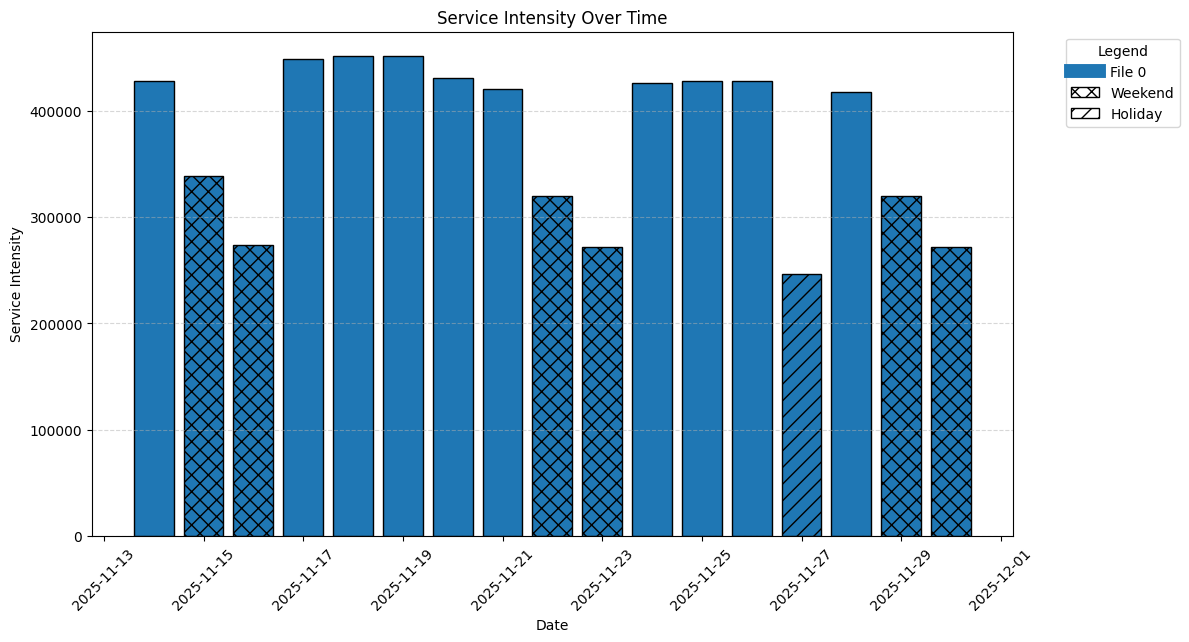

In [7]:
service_intensity = gtfs.get_service_intensity_in_date_range(
    start_date=None, # If None take the feed min date
    end_date=None, # If None take the feed max date
    date_type=None, # Could be something like 'holiday', 'weekday', or 'monday' to only consider some dates from the range.
    by_feed=True
)
service_intensity = service_intensity.to_pandas()
plot_helper.plot_service_intensity(service_intensity)

We use the ``selected_day`` variable to select the most representative business day in a date range. The rest of the analysis will focus on this particular date.

In [8]:
selected_service_intensity = gtfs.get_service_intensity_in_date_range(
    start_date=None, # If None take the feed min date
    end_date=None, # If None take the feed max date
    date_type='businessday' # Could be something like 'holiday', 'businessday', 'non_businessday', or 'monday' to only consider some dates from the range.
)
selected_service_intensity = selected_service_intensity.to_pandas()
idx = processing_helper.most_frequent_row_index(selected_service_intensity['service_intensity'])
selected_day = selected_service_intensity.iloc[idx]['date'].to_pydatetime()
selected_day

datetime.datetime(2025, 11, 25, 0, 0)

In [9]:
date = selected_day

### Analysis 2: Frequency by stop - Average waiting time (interval in minutes) at stops

In this example we use the *shape_direction* mode 

- Uses direction (shape_direction) in degrees from north that every 'trip_id' is pointing to computed at every stop and every trip
- Creates 'n_divisions' * 2 groups (*2 to get outbound and inbound directions independently) by clustering the trip shape directions 
- If how = 'best' means the interval is computed only for the best of all divisions at every stop 

**Note:** This uses parameters ``START_TIME``, ``END_TIME``, ``ROUTE_TYPES`` and ``STOP_ID_FIELD`` defined in earlier sections. In particular, we restricted the time of the day to **8am -- 8pm** for the analysis (which does not fully cover AM peak as the MBTA defined).

In [10]:
def df_to_stop_gdf(df):
    if isinstance(df,pl.LazyFrame):
        df = df.collect()
    if isinstance(df, pl.DataFrame):
        df = df.to_pandas()

    df = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df['stop_lon'],df['stop_lat']),crs=4326)
    return df 

In [11]:
stop_interval_df = gtfs.get_mean_interval_at_stops(
    date=selected_day,
    start_time=START_TIME,
    end_time=END_TIME,
    route_types=ROUTE_TYPES, 
    by = "shape_direction", # Interval is computed for all 'trip_id' grouped by this column and sorted by 'departure_time'
    at = STOP_ID_FIELD, # Where to compute the interval 'stop_id' 'parent_station'
    how = "best", 
    # 'best' pick the route with best interval, 
    # 'mean' Combine all intervals of all routes, 
    # 'all' return results per stop and route
    n_divisions=1, # Number of divisions for by = 'shape_direction'
    # mix_directions=False # For how = 'mean' do you want to consider both directions as different routes?
).to_pandas()
stop_interval_df = gtfs.add_stop_coords(stop_interval_df)
stop_interval_df = gtfs.add_route_names(stop_interval_df)
stop_interval_df = df_to_stop_gdf(stop_interval_df)
stop_interval_df = stop_interval_df.sort_values(STOP_ID_FIELD).reset_index(drop=True)
stop_interval_df = stop_interval_df[stop_interval_df.geometry.is_valid]
stop_interval_df

,parent_station,shape_direction,shape_ids,mean_interval,stop_lat,stop_lon,stop_name,route_short_names,route_long_names,route_names,route_ids,route_types,route_type_texts,geometry
0,10000_file_0,16.412826,"[70936190_file_0, 70939084_file_0, 71194341_fi...",2.375000,42.356307,-71.062485,Tremont_St_opp_Temple_Pl,"[None, E, C, D, B]","[Red_Line, Green_Line_E, Green_Line_C, Green_L...","[Red_Line, E, C, D, B]","[Red_file_0, Green-E_file_0, Green-C_file_0, G...","[1, 0]","[subway, tram]",POINT (-71.06248 42.35631)
1,10003_file_0,48.508926,"[71365515_file_0, 71375293_file_0, 71362061_fi...",9.041667,42.331633,-71.076292,Albany_St_opp_Randall_St,"[1, 47]","[Harvard_Square_-_Nubian_Station, Central_Squa...","[1, 47]","[1_file_0, 47_file_0]",[3],[bus],POINT (-71.07629 42.33163)
2,10005_file_0,308.305056,"[71374475_file_0, 71378987_file_0, 71378876_fi...",20.411111,42.335017,-71.071280,Albany_St_opp_E_Concord_St,"[8, 10]","[Harbor_Point_-_Kenmore_Station, City_Point_-_...","[8, 10]","[8_file_0, 10_file_0]",[3],[bus],POINT (-71.07128 42.33502)
3,10006_file_0,79.193483,"[71363441_file_0, 71374722_file_0, 71362310_fi...",20.880556,42.335814,-71.070135,Albany_St_opp_E_Newton_St,[47],"[Central_Square,_Cambridge_-_Broadway_Station]",[47],[47_file_0],[3],[bus],POINT (-71.07014 42.33581)
4,10007_file_0,77.476415,"[71363441_file_0, 71362310_file_0, 71374722_fi...",20.908333,42.338366,-71.066611,540_Albany_St_opp_Wareham_St,[47],"[Central_Square,_Cambridge_-_Broadway_Station]",[47],[47_file_0],[3],[bus],POINT (-71.06661 42.33837)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916,place-sull_file_0,193.432761,"[71994180_file_0, 71888632_file_0, 71375232_fi...",3.855556,42.384081,-71.076464,place-sull,"[93, CT2, 92, 91, 90, None, 109]",[Sullivan_Square_Station_-_Downtown_via_Bunker...,"[93, CT2, 92, 91, 90, Orange_Line, 109]","[93_file_0, 747_file_0, 92_file_0, 91_file_0, ...","[3, 1]","[bus, subway]",POINT (-71.07646 42.38408)
3917,place-unsqu_file_0,215.819699,[71193557_file_0],8.205556,42.377007,-71.093978,place-unsqu,[D],[Green_Line_D],[D],[Green-D_file_0],[0],[tram],POINT (-71.09398 42.37701)
3918,place-welln_file_0,4.166343,"[71996458_file_0, 71888427_file_0, 71994505_fi...",4.266667,42.402327,-71.076288,place-welln,"[134, 97, 108, 100, 106, 99, None]","[North_Woburn_-_Wellington_Station, Malden_Cen...","[134, 97, 108, 100, 106, 99, Orange_Line]","[134_file_0, 97_file_0, 108_file_0, 100_file_0...","[3, 1]","[bus, subway]",POINT (-71.07629 42.40233)
3919,place-wimnl_file_0,235.162142,"[71993438_file_0, 71887920_file_0, 71826035_fi...",5.072222,42.379926,-71.022963,place-wimnl,"[112, 121, None, 120]","[Wellington_Station_-_Wood_Island_Station, Woo...","[112, 121, Blue_Line, 120]","[112_file_0, 121_file_0, Blue_file_0, 120_file_0]","[3, 1]","[bus, subway]",POINT (-71.02296 42.37993)


Illustrating the data in an interactive map:

In [12]:
m = stop_interval_df[
    [
        STOP_ID_FIELD,
        "mean_interval",
        "stop_name",
        "route_names",
        "route_type_texts",
        "geometry",
    ]
].explore(
    column=f"mean_interval",
    cmap="RdYlGn_r",
    vmin=5,
    vmax=30,
    style_kwds={
        "color": "black",  # Border color
        "weight": 1,  # Border thickness
        "opacity": 1.0,  # Border opacity
        "fillOpacity": 1,
        "radius": 6,
    },
)
m

If you want the frequency (interval in minutes) per **route** and **stop**:

In [13]:
stop_route_interval_df = gtfs.get_mean_interval_at_stops(
    date=selected_day,
    start_time=START_TIME,
    end_time=END_TIME,
    route_types=ROUTE_TYPES, 
    by = "route_id", # Interval is computed for all 'trip_id' grouped by this column and sorted by 'departure_time'
    at = STOP_ID_FIELD, # Where to compute the interval 'stop_id' 'parent_station'
    how = "best", 
    # 'best' pick the route with best interval, 
    # 'mean' Combine all intervals of all routes, 
    # 'all' return results per stop and route
    n_divisions=1, # Number of divisions for by = 'shape_direction'
    # mix_directions=False # For how = 'mean' do you want to consider both directions as different routes?
).to_pandas()
stop_route_interval_df = gtfs.add_stop_coords(stop_route_interval_df)
stop_route_interval_df = gtfs.add_route_names(stop_route_interval_df)
stop_route_interval_df = df_to_stop_gdf(stop_route_interval_df)
stop_route_interval_df = stop_route_interval_df.sort_values(STOP_ID_FIELD).reset_index(drop=True)
stop_route_interval_df = stop_route_interval_df[stop_route_interval_df.geometry.is_valid]
stop_route_interval_df

,parent_station,route_id,shape_direction,direction_id,mean_interval,stop_lat,stop_lon,stop_name,route_short_name,route_long_name,route_name,route_type,route_type_text,geometry
0,10000_file_0,Red_file_0,168.709053,0,5.111111,42.356307,-71.062485,Tremont_St_opp_Temple_Pl,None,Red_Line,Red_Line,1,subway,POINT (-71.06248 42.35631)
1,10003_file_0,1_file_0,329.428432,0,11.072222,42.331633,-71.076292,Albany_St_opp_Randall_St,1,Harvard_Square_-_Nubian_Station,1,3,bus,POINT (-71.07629 42.33163)
2,10005_file_0,47_file_0,50.325325,1,20.858333,42.335017,-71.071280,Albany_St_opp_E_Concord_St,47,"Central_Square,_Cambridge_-_Broadway_Station",47,3,bus,POINT (-71.07128 42.33502)
3,10006_file_0,47_file_0,51.109844,1,20.880556,42.335814,-71.070135,Albany_St_opp_E_Newton_St,47,"Central_Square,_Cambridge_-_Broadway_Station",47,3,bus,POINT (-71.07014 42.33581)
4,10007_file_0,47_file_0,56.576989,1,20.908333,42.338366,-71.066611,540_Albany_St_opp_Wareham_St,47,"Central_Square,_Cambridge_-_Broadway_Station",47,3,bus,POINT (-71.06661 42.33837)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916,place-sull_file_0,Orange_file_0,183.290225,0,5.583333,42.384081,-71.076464,place-sull,None,Orange_Line,Orange_Line,1,subway,POINT (-71.07646 42.38408)
3917,place-unsqu_file_0,Green-D_file_0,215.819699,0,8.205556,42.377007,-71.093978,place-unsqu,D,Green_Line_D,D,0,tram,POINT (-71.09398 42.37701)
3918,place-welln_file_0,Orange_file_0,182.071817,0,5.583333,42.402327,-71.076288,place-welln,None,Orange_Line,Orange_Line,1,subway,POINT (-71.07629 42.40233)
3919,place-wimnl_file_0,Blue_file_0,46.160893,1,5.519444,42.379926,-71.022963,place-wimnl,None,Blue_Line,Blue_Line,1,subway,POINT (-71.02296 42.37993)


Frequency (the ``mean_interval`` column) by transit route:

In [14]:
# Mean interval by route 
if "route_id" not in stop_route_interval_df.columns:
    raise Exception("You should compute get_mean_interval_at_stops with by = 'route_id' to compute route means")

route_interval = (
    stop_route_interval_df
    .groupby('route_id')
    .agg(mean_interval=('mean_interval', 'mean'))
    .reset_index()
)
route_interval = gtfs.add_route_names(route_interval)
route_interval

,route_id,mean_interval,route_short_name,route_long_name,route_name,route_type,route_type_text
0,100_file_0,29.685380,100,Elm_Street_-_Wellington_Station,100,3,bus
1,101_file_0,23.925000,101,Malden_Center_Station_-_Sullivan_Square_Statio...,101,3,bus
2,104_file_0,14.534420,104,Malden_Center_Station_-_Airport_Station,104,3,bus
3,105_file_0,69.112963,105,Malden_Center_Station_-_Sullivan_Square_Statio...,105,3,bus
4,106_file_0,37.790856,106,Lebanon_Loop_-_Wellington_Station,106,3,bus
...,...,...,...,...,...,...,...
165,Green-D_file_0,8.036806,D,Green_Line_D,D,0,tram
166,Green-E_file_0,7.553439,E,Green_Line_E,E,0,tram
167,Mattapan_file_0,8.220486,None,Mattapan_Trolley,Mattapan_Trolley,0,tram
168,Orange_file_0,5.582716,None,Orange_Line,Orange_Line,1,subway


Average frequency in the whole system: (Note this is an unweighted mean over all transit stops, which are overwhelmingly bus stops on infrequent routes)

In [15]:
# Mean interval in whole system 
system_interval = float(
    np.nanmean(stop_interval_df['mean_interval'])
)

print(f"The average waiting time (interval) in the system is {round(system_interval,ndigits=2)} minutes")

The average waiting time (interval) in the system is 66.76 minutes


## Other Analyses: External Tutorial

See [this ``CityScope/pyGTFSHandler`` tutorial](https://github.com/CityScope/pyGTFSHandler/blob/main/tutorial/tutorial.ipynb) for more functionalities and examples of analyses, such as:

* Analyzing the (scheduled) **speed** of transit services at each stop and for each route
* Filtering stops by geographical regions (e.g. the City of Cambridge)
* Pooling GTFS data from transit agencies other than the MBTA

## GTFS DataFrame Column Reference

This section lists important columns and data tables in GTFS for quick reference.

As a reminder, you can find the full documentation for the generic GTFS format [here](https://gtfs.org/documentation/schedule/reference/). MBTA provides additional documentation in [this GitHub repo](https://github.com/mbta/gtfs-documentation) to complement the former.

The fields are grouped by theme for clarity.

### Core GTFS Identifiers

| Column             | Description                                                                                                                 |
| ------------------ | --------------------------------------------------------------------------------------------------------------------------- |
| **service_id**     | Unique identifier for a service pattern or calendar day. For example, all weekday services may share the same `service_id`. |
| **route_id**       | Unique identifier for each transit line (e.g., Red Line).                                                                   |
| **trip_id**        | Unique identifier for each individual trip (one vehicle going from start to end at specific times).                         |
| **shape_id**       | Unique identifier for a line geometry. Trips sharing the same physical path but different timing use the same `shape_id`.   |
| **direction_id**        | Unique identifier for each route direction [0 or 1]. 
| **stop_id**        | Unique identifier for each stop.                                                                                            |
| **parent_station** | Identifier grouping related stops (e.g., opposite-direction platforms at one station).                                      |

### Stop Times

| Column             | Description                                              |
| ------------------ | -------------------------------------------------------- |
| **departure_time** | Departure time from the stop, in seconds after midnight. |
| **arrival_time**   | Arrival time at the stop, in seconds after midnight.     |
| **stop_sequence**  | Ordering of stops within a trip (1 = first stop).        |

### Shape / Geometry Details

| Column                        | Description                                                                                                         |
| ----------------------------- | ------------------------------------------------------------------------------------------------------------------- |
| **shape_time_traveled**       | Time elapsed since the first stop, computed from geometry.                                                          |
| **shape_total_travel_time**   | Total computed travel time of the trip.                                                                             |
| **shape_dist_traveled**       | Distance from the starting point of the shape, in meters.                                                           |
| **shape_total_distance**      | Total distance of the trip, in meters.                                                                              |
| **shape_direction**           | Average forward direction of travel at this stop (angle based on this stop and the average of all upcoming stops).  |
| **shape_direction_backwards** | Average backward direction of travel at this stop (angle based on this stop and the average of all previous stops). |

### Frequency-Based Scheduling (GTFS-Frequencies)

These columns appear when the GTFS uses frequency-based definitions instead of explicit scheduled trips.

| Column           | Description                                                                                             |
| ---------------- | ------------------------------------------------------------------------------------------------------- |
| **start_time**   | Start of the frequency window, in days since 01-01-1970.                                                |
| **end_time**     | End of the frequency window, same unit as above.                                                        |
| **headway_secs** | Frequency of a repeated trip, in seconds. The trip repeats every `headway_secs` from start to end time. |
| **n_trips**      | Number of trips represented by the frequency specification.                                             |

### GTFS Source Metadata

| Column        | Description                                             |
| ------------- | ------------------------------------------------------- |
| **gtfs_name** | Name of the GTFS source file that contributed this row. |
| **file_id**   | Index of the GTFS file in the list of `file_paths`.     |

### Route Type

| Column         | Description                                                                                                                                                                                                                                                                                                                |
| -------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **route_type** | GTFS route type, either numeric or string-normalized using your provided function. Valid mapped values: <br><br> **0** – Tram / Streetcar <br> **1** – Subway / Metro <br> **2** – Rail <br> **3** – Bus <br> **4** – Ferry <br> **5** – Cable Car <br> **6** – Gondola / Suspended cable transport <br> **7** – Funicular |

String inputs such as `"tram"`, `"subway"`, `"bus"`, `"cable car"` etc. are automatically normalized.

### Spatial Attributes

| Column       | Description                                                                 |
| ------------ | --------------------------------------------------------------------------- |
| **isin_aoi** | Boolean: whether the stop lies inside the defined Area of Interest polygon. |
